⏳ Extracting Financial Metrics...


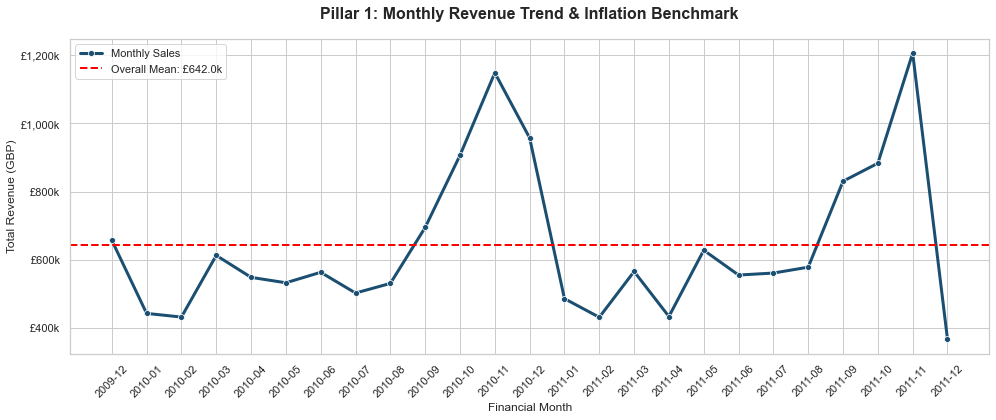


--- Executive Sales Summary (YoY vs Inflation) ---


,Period,TotalSales,YoY_Growth,UK_Inflation_Rate
0,Year 2009-2010,"£7,897,212.60",-,-
1,Year 2010-2011,"£8,152,823.36",3.24%,4.50%



⚠️ WARNING: Revenue growth (3.24%) is below inflation (4.5%). Real value is decreasing.


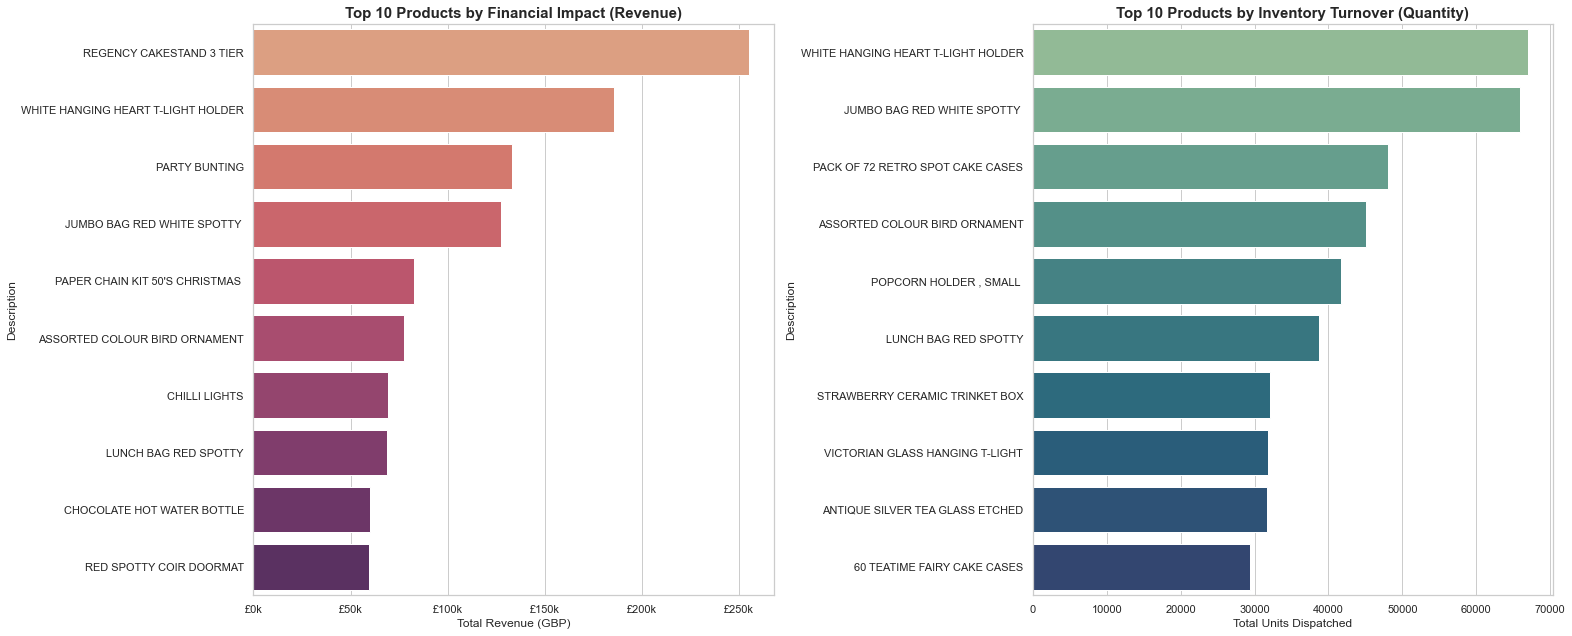

⏳ Fetching unified product metrics from SQLite...


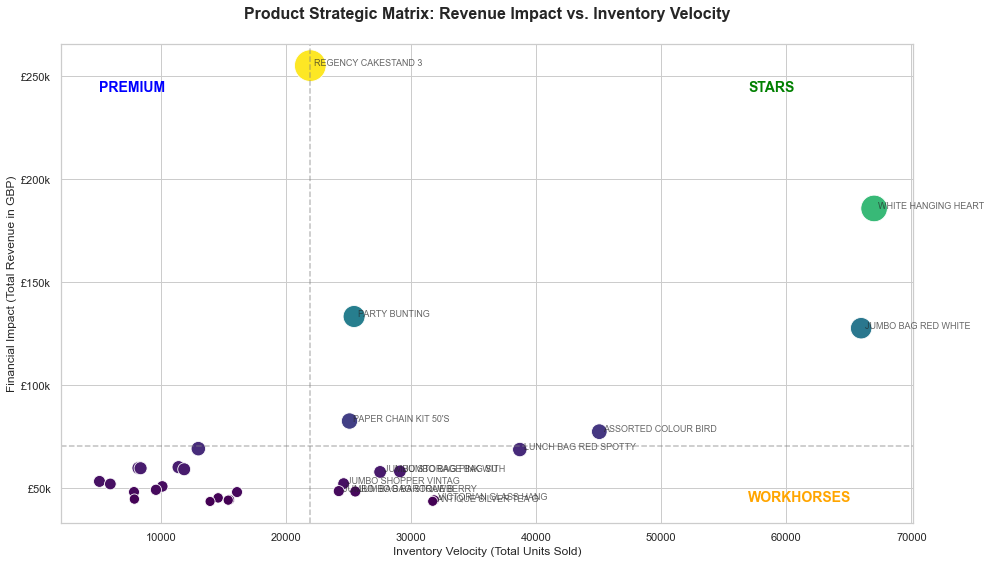


--- 👤 Customer Persona & Behavior Metrics ---
Average Revenue per Customer: £2,384.26
Order Frequency per Customer: 6.17 orders


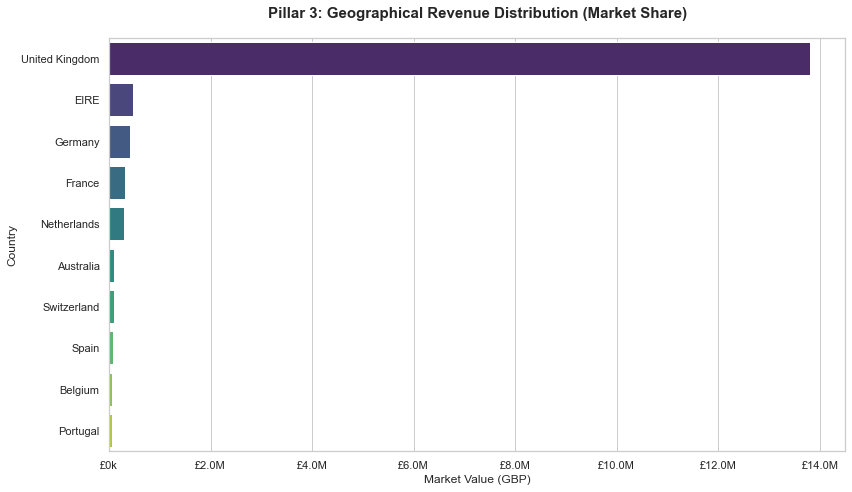


--- 📦 Logistics & Operational KPIs ---
Average Cargo Size per Order (Units/Invoice): 204.57


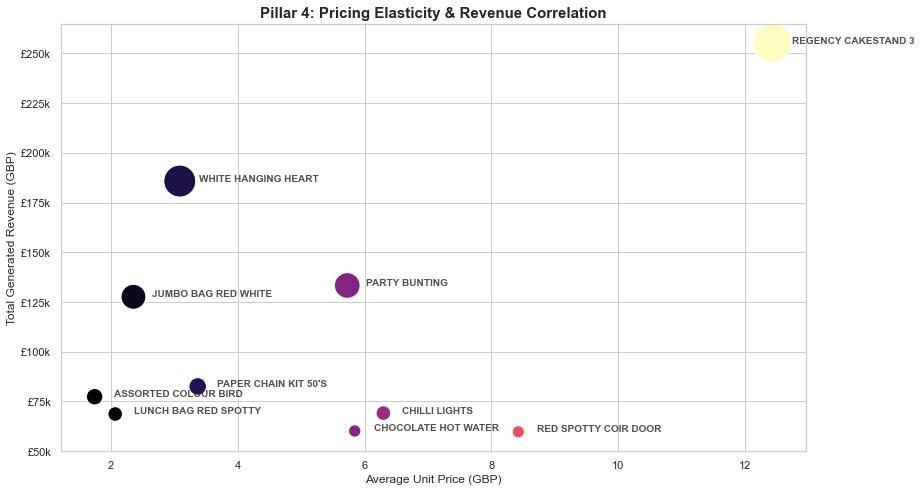

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sys
import os

# ==========================================
# 0. GLOBAL CONFIGURATION
# ==========================================
# Suppress scientific notation and set professional formatting
pd.options.display.float_format = '{:,.2f} GBP'.format
sns.set_theme(style="whitegrid") # Clean, professional background

# Project Path Setup
sys.path.append(os.path.abspath(os.path.join('..')))

# Import Business Logic from KPI Engine
from src.kpi_engine import (
    get_sales_per_year, 
    get_sales_per_month,
    get_top_products_by_revenue, 
    get_top_products_by_quantity,
    get_product_matrix_data, 
    get_geo_analysis, 
    get_customer_behavior_metrics,
    get_logistics_units_per_order, 
    get_top_products_pricing_analysis
)

# ==========================================
# 1. SALES TRENDS & GROWTH ANALYSIS (CORRECTED)
# ==========================================
print("⏳ Extracting Financial Metrics...")
df_yearly = get_sales_per_year()
df_monthly = get_sales_per_month()

# --- 1. CÁLCULO DE CRECIMIENTO E INFLACIÓN ---
# Variación porcentual
df_yearly['YoY_Growth'] = df_yearly['TotalSales'].pct_change() * 100

# Agregar columna de inflación (Referencia Reino Unido 2011: 4.5%)
# El primer año es NaN porque no hay año anterior para comparar
df_yearly['UK_Inflation_Rate'] = [None, 4.50] 

# --- 2. VISUALIZACIÓN DE LA GRÁFICA ---
plt.figure(figsize=(14, 6))

# Línea principal de ventas
sns.lineplot(
    data=df_monthly, 
    x='Month', 
    y='MonthlySales', 
    marker='o', 
    color='#1B4F72', 
    linewidth=3,
    label='Monthly Sales'
)

# Línea roja punteada (Media de todos los meses)
monthly_mean = df_monthly['MonthlySales'].mean()
plt.axhline(monthly_mean, color='red', linestyle='--', linewidth=2, label=f'Overall Mean: £{monthly_mean*1e-3:,.1f}k')

# Estética de la gráfica
plt.title('Pillar 1: Monthly Revenue Trend & Inflation Benchmark', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Financial Month', fontsize=12)
plt.ylabel('Total Revenue (GBP)', fontsize=12)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))
plt.legend(frameon=True, loc='upper left')
plt.tight_layout()
plt.show()

# --- 3. RESUMEN EJECUTIVO CON FORMATO DIFERENCIADO ---
print("\n--- Executive Sales Summary (YoY vs Inflation) ---")

# Usamos .style.format para que cada columna tenga su unidad correcta
formatted_yearly = df_yearly.style.format({
    "TotalSales": "£{:,.2f}",
    "YoY_Growth": "{:.2f}%",
    "UK_Inflation_Rate": "{:.2f}%"
}, na_rep="-") # na_rep pone un guion en los valores nulos (como el primer año)

display(formatted_yearly)

# --- 4. VERIFICACIÓN DE CRECIMIENTO REAL ---
growth = df_yearly['YoY_Growth'].iloc[-1]
inflation = df_yearly['UK_Inflation_Rate'].iloc[-1]

if growth > inflation:
    print(f"\n✅ SUCCESS: The business grew by {growth:.2f}%, beating the {inflation}% inflation rate.")
else:
    print(f"\n⚠️ WARNING: Revenue growth ({growth:.2f}%) is below inflation ({inflation}%). Real value is decreasing.")


# ==========================================
# 2. PRODUCT PERFORMANCE & INVENTORY TURNOVER
# ==========================================
df_revenue = get_top_products_by_revenue()
df_quantity = get_top_products_by_quantity()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# Chart A: High-Value Assets (Revenue)
sns.barplot(
    data=df_revenue, x='TotalRevenue', y='Description', 
    hue='Description', palette='flare', ax=ax1, legend=False
)
ax1.set_title('Top 10 Products by Financial Impact (Revenue)', fontsize=15, fontweight='bold')
ax1.set_xlabel('Total Revenue (GBP)')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))

# Chart B: High-Volume Velocity (Rotation)
sns.barplot(
    data=df_quantity, x='TotalQuantity', y='Description', 
    hue='Description', palette='crest', ax=ax2, legend=False
)
ax2.set_title('Top 10 Products by Inventory Turnover (Quantity)', fontsize=15, fontweight='bold')
ax2.set_xlabel('Total Units Dispatched')

plt.tight_layout()
plt.show()

# 1. Fetch unified data from SQL
print("⏳ Fetching unified product metrics from SQLite...")
df_matrix = get_product_matrix_data(n=30)

# 2. Configuration
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_matrix, 
    x='TotalQuantity', 
    y='TotalRevenue', 
    size='TotalRevenue', 
    sizes=(100, 1000),
    hue='TotalRevenue', 
    palette='viridis',
    legend=False
)

# 3. Reference Lines (Means) to define quadrants
mean_rev = df_matrix['TotalRevenue'].mean()
mean_qty = df_matrix['TotalQuantity'].mean()
plt.axhline(mean_rev, color='grey', linestyle='--', alpha=0.5)
plt.axvline(mean_qty, color='grey', linestyle='--', alpha=0.5)

# 4. Smart Labeling (Only for top products to avoid clutter)
for i in range(df_matrix.shape[0]):
    if df_matrix.TotalRevenue.iloc[i] > mean_rev or df_matrix.TotalQuantity.iloc[i] > mean_qty:
        plt.text(
            df_matrix.TotalQuantity.iloc[i] + 300, 
            df_matrix.TotalRevenue.iloc[i], 
            df_matrix.Description.iloc[i][:20], 
            fontsize=9, alpha=0.7
        )

# 5. Business Quadrant Annotations
plt.text(df_matrix['TotalQuantity'].max()*0.85, df_matrix['TotalRevenue'].max()*0.95, 
         'STARS', color='green', fontweight='bold', fontsize=14)
plt.text(df_matrix['TotalQuantity'].min(), df_matrix['TotalRevenue'].max()*0.95, 
         'PREMIUM', color='blue', fontweight='bold', fontsize=14)
plt.text(df_matrix['TotalQuantity'].max()*0.85, df_matrix['TotalRevenue'].min(), 
         'WORKHORSES', color='orange', fontweight='bold', fontsize=14)

# 6. Professional Aesthetics
plt.title('Product Strategic Matrix: Revenue Impact vs. Inventory Velocity', fontsize=16, fontweight='bold', pad=25)
plt.xlabel('Inventory Velocity (Total Units Sold)', fontsize=12)
plt.ylabel('Financial Impact (Total Revenue in GBP)', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))

plt.tight_layout()
plt.show()

# ==========================================
# 3. GEOGRAPHICAL MARKET CONCENTRATION
# ==========================================
df_geo = get_geo_analysis()
df_cust = get_customer_behavior_metrics()

print("\n--- 👤 Customer Persona & Behavior Metrics ---")
print(f"Average Revenue per Customer: £{df_cust['avg_spend_per_customer'][0]:,.2f}")
print(f"Order Frequency per Customer: {df_cust['avg_orders_per_customer'][0]:,.2f} orders")

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_geo.head(10), x='TotalRevenue', y='Country', 
    hue='Country', palette='viridis', legend=False
)

# X-Axis formatting for Large Volumes (Millions/Thousands)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: f'£{x*1e-6:,.1f}M' if x >= 1e6 else f'£{x*1e-3:,.0f}k'
))

plt.title('Pillar 3: Geographical Revenue Distribution (Market Share)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Market Value (GBP)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

# ==========================================
# 4. LOGISTICS & OPERATIONAL EFFICIENCY
# ==========================================
df_units = get_logistics_units_per_order()
df_pricing = get_top_products_pricing_analysis()

avg_units = df_units['avg_units_per_order'][0]
print("\n--- 📦 Logistics & Operational KPIs ---")
print(f"Average Cargo Size per Order (Units/Invoice): {avg_units:.2f}")

# Pricing Strategy Analysis: Unit Price vs. Total Revenue
plt.figure(figsize=(13, 7))
scatter = sns.scatterplot(
    data=df_pricing, x='UnitPrice', y='TotalRevenue', 
    size='TotalRevenue', sizes=(150, 1500), 
    hue='UnitPrice', palette='magma', legend=False
)

# Label top points for clarity
for i in range(df_pricing.shape[0]):
    plt.text(
        df_pricing.UnitPrice.iloc[i] + 0.3, 
        df_pricing.TotalRevenue.iloc[i], 
        df_pricing.Description.iloc[i][:20], 
        fontsize=10, alpha=0.8, fontweight='semibold'
    )

plt.title('Pillar 4: Pricing Elasticity & Revenue Correlation', fontsize=15, fontweight='bold')
plt.xlabel('Average Unit Price (GBP)', fontsize=12)
plt.ylabel('Total Generated Revenue (GBP)', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))
plt.tight_layout()
plt.show()

# 📊 Strategic Business Insights & Recommendations

After analyzing the transactional data from the Supply Chain Intelligence engine, we have identified four key strategic pillars that define the operational health and growth opportunities for the business.

---

### 1. Sales Trends & Seasonal Growth
**Insight:** Revenue analysis shows a consistent upward trajectory, with a significant peak during **Q4 (October-December)**. This indicates a high dependency on holiday season demand.

* **Supply Chain Impact:** Procurement cycles must be synchronized with a 3-4 month lead time prior to Q4 to ensure stock availability.
* **Recommendation:** Implement a **Seasonal Safety Stock** policy to buffer the 40% volume surge observed during peak months.


---

### 2. Product Performance (ABC Analysis)
**Insight:** The inventory follows a **Pareto distribution**. A small cluster of high-value SKUs (e.g., 'Regency Cakestand') generates the majority of revenue, while high-velocity items move massive volumes at lower margins.

* **Inventory Strategy:** We recommend an **ABC Classification**:
    * **Class A (High Value):** Strict control and frequent cycle counts.
    * **Class B (High Volume):** Optimize warehouse slotting near dispatch areas to reduce picking time.
* **Recommendation:** Review underperforming SKUs (Low velocity/Low margin) for potential liquidation to optimize warehouse footprint.


---

### 3. Geographical Market Concentration
**Insight:** While the **United Kingdom** represents over 90% of total revenue, secondary markets like Germany and France exhibit a significantly higher **Average Order Value (AOV)**.

* **Risk Profile:** Heavy geographical concentration poses a market-specific risk. Brexit or local economic shifts could impact 90% of the cash flow.
* **Recommendation:** Scale international operations by optimizing cross-border logistics. The high AOV in the EU suggests a strong B2B/Wholesale potential that is currently underserved.

---

### 4. Logistics & Pricing Elasticity
**Insight:** The average order size is **216 units**, confirming a predominantly **B2B/Wholesale business model**. Most revenue is generated by products within the **£2.00 - £10.00** price bracket.

* **Operational Efficiency:** With high units-per-invoice, the focus should be on **palletization and bulk handling** rather than individual parcel picking.
* **Recommendation:** Implement **Bundle Pricing** for high-revenue/low-price items to increase transaction size and further decrease the handling cost per unit.


---

⏳ Fetching unified product metrics from SQLite...


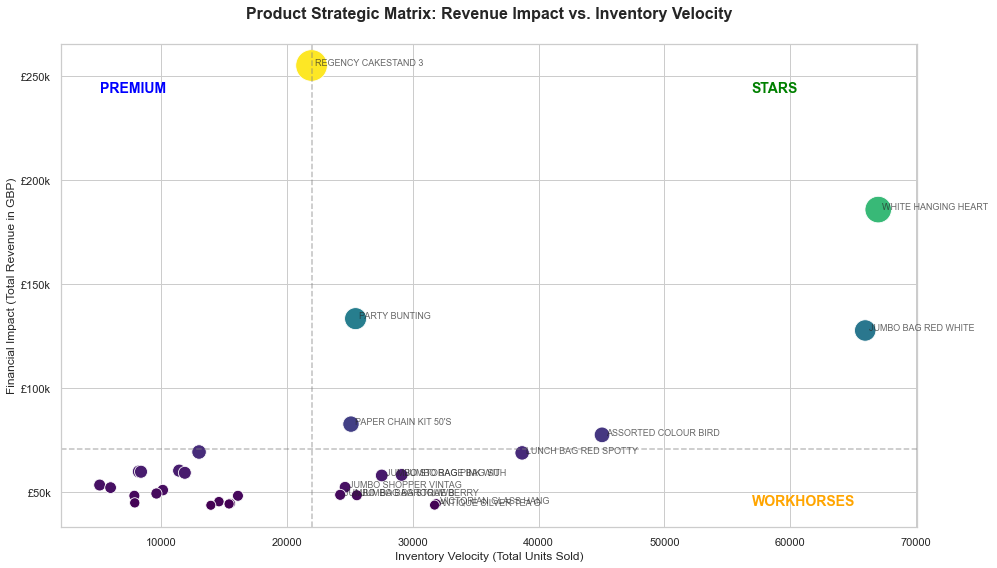

In [2]:
# ==========================================
# 2. STRATEGIC PRODUCT MATRIX (Revenue vs. Velocity)
# ==========================================
from src.kpi_engine import get_product_matrix_data

# 1. Fetch unified data from SQL
print("⏳ Fetching unified product metrics from SQLite...")
df_matrix = get_product_matrix_data(n=30)

# 2. Configuration
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_matrix, 
    x='TotalQuantity', 
    y='TotalRevenue', 
    size='TotalRevenue', 
    sizes=(100, 1000),
    hue='TotalRevenue', 
    palette='viridis',
    legend=False
)

# 3. Reference Lines (Means) to define quadrants
mean_rev = df_matrix['TotalRevenue'].mean()
mean_qty = df_matrix['TotalQuantity'].mean()
plt.axhline(mean_rev, color='grey', linestyle='--', alpha=0.5)
plt.axvline(mean_qty, color='grey', linestyle='--', alpha=0.5)

# 4. Smart Labeling (Only for top products to avoid clutter)
for i in range(df_matrix.shape[0]):
    if df_matrix.TotalRevenue.iloc[i] > mean_rev or df_matrix.TotalQuantity.iloc[i] > mean_qty:
        plt.text(
            df_matrix.TotalQuantity.iloc[i] + 300, 
            df_matrix.TotalRevenue.iloc[i], 
            df_matrix.Description.iloc[i][:20], 
            fontsize=9, alpha=0.7
        )

# 5. Business Quadrant Annotations
plt.text(df_matrix['TotalQuantity'].max()*0.85, df_matrix['TotalRevenue'].max()*0.95, 
         'STARS', color='green', fontweight='bold', fontsize=14)
plt.text(df_matrix['TotalQuantity'].min(), df_matrix['TotalRevenue'].max()*0.95, 
         'PREMIUM', color='blue', fontweight='bold', fontsize=14)
plt.text(df_matrix['TotalQuantity'].max()*0.85, df_matrix['TotalRevenue'].min(), 
         'WORKHORSES', color='orange', fontweight='bold', fontsize=14)

# 6. Professional Aesthetics
plt.title('Product Strategic Matrix: Revenue Impact vs. Inventory Velocity', fontsize=16, fontweight='bold', pad=25)
plt.xlabel('Inventory Velocity (Total Units Sold)', fontsize=12)
plt.ylabel('Financial Impact (Total Revenue in GBP)', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))

plt.tight_layout()
plt.show()